Apply the Optimization code to predict dolphin hunting parties of [3, 4, 6, 8, 10] with the conditions that the cost function increase by square of the pairwise distance if the dolphins are too far apart, and increases by inverse square of the pairwise distance if they are too close together.

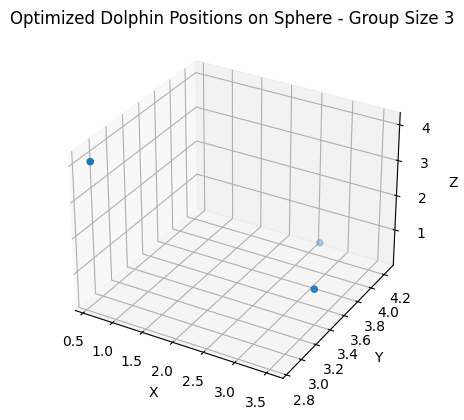

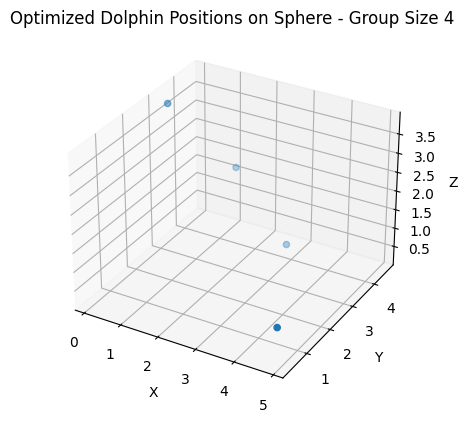

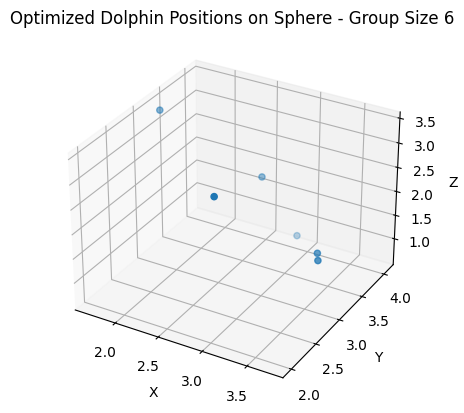

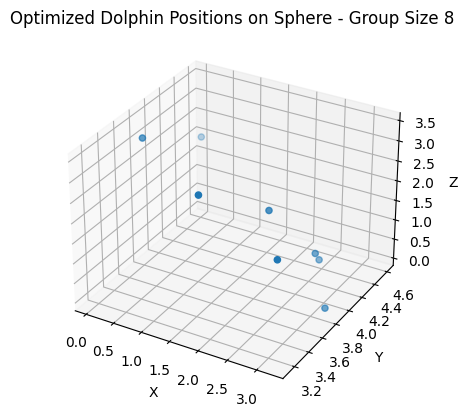

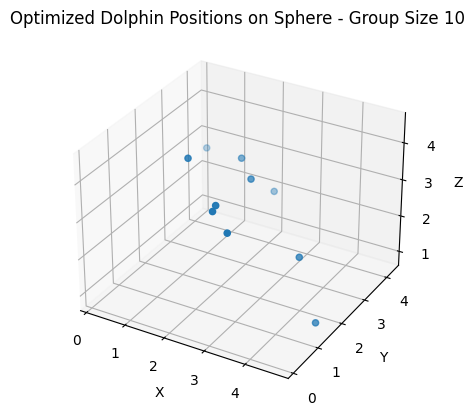

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class Nelder_Mead:
    def __init__(self, dim, distance_cost_func, param=None):
        self.dim = dim


        self.simplex = np.zeros(dim*(dim + 1))
        self.simplex = np.reshape(self.simplex, (dim + 1, dim))

        self.param = param
        self.distance_cost_func = distance_cost_func
        self.val = np.zeros(dim + 1)
        self.alpha = 1.0
        self.beta = 0.5
        self.gamma = 2.0
        self.delta = 0.5


    def get(self, index, entry=None):
        if entry is None:
            return self.val[index], self.simplex[index]
        else:
            self.simplex[index] = np.array(entry)
            self.val[index] = self.calculate_cost(entry)
            return self.val[index], self.simplex[index]

    def __getitem__(self, index):
        return self.get(index)

    def __setitem__(self, index, entry):
        return self.get(index, entry)

    def max_min(self):
        indices = np.argsort(self.val)
        return indices[-1], indices[0]

    def sorted_index(self, index):
        indices = np.argsort(self.val)
        return indices[index]

    def centroid(self):
        max, min = self.max_min()
        p_bar = np.zeros(self.dim)
        for i in range(max):
            p_bar += self.simplex[i]
        for i in range(max + 1, self.dim + 1):
            p_bar += self.simplex[i]

        p_bar = p_bar/self.dim
        return p_bar

    def reflect(self, p_bar, p):
        return (1 + self.alpha) * p_bar - self.alpha * p

    def expand(self, p_bar, p):
        return self.gamma * p + (1 - self.gamma) * p_bar

    def contract(self, p_bar, p):
        return self.beta * p + (1 - self.beta) * p_bar

    def point_shrink(self, pl, p):
        return self.delta * p + (1 - self.delta) * pl

    def rmsd(self):
        average = 0.0
        square_average = 0.0
        for entry in self.val:
            average += entry
            square_average += entry * entry
        average /= self.dim
        square_average /= self.dim
        return np.sqrt(np.abs(square_average - average*average))

    def calculate_cost(self, entry):
        if self.param is None:
            return self.distance_cost_func(entry)
        else:
            return self.distance_cost_func(entry, self.param)

    def nelder_mead_step(self):
        max_original, min_original = self.max_min()
        max_second = self.sorted_index(-2)
        p_bar = self.centroid()
        p_r = self.reflect(p_bar, self.simplex[max_original])

        val_r = self.calculate_cost(p_r)

        if val_r >= self.val[min_original] and val_r < self.val[max_second]:
            self.get(max_original, p_r)
            return self.val[min_original], min_original, self.rmsd(), 'reflect'

        if val_r < self.val[min_original]:
            p_ex = self.expand(p_bar, p_r)
            val_ex = self.calculate_cost(p_ex)

            if val_ex < val_r:
                self.get(max_original, p_ex)
                return val_ex, max_original, self.rmsd(), 'expand'
            else:
                self.get(max_original, p_r)
                return val_r, max_original, self.rmsd(), 'reflect'

        if val_r >= self.val[max_second]:
            if val_r < self.val[max_original]:
                p_c = self.contract(p_bar, p_r)
                val_c = self.calculate_cost(p_c)
                if val_c < val_r:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
            if val_r >= self.val[max_original]:
                p_c = self.contract(p_bar, self.simplex[max_original])
                val_c = self.calculate_cost(p_c)
                if val_c < self.val[max_original]:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract2'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
    def initialize_simplex(self):
            # Initialize simplex based on the number of dolphins
        self.simplex = np.random.rand(self.dim + 1, self.dim)


    def optimize(self):
        rms = 1.0
        while rms > 1e-4:
            val, index, rms, step_name = self.nelder_mead_step()
            #print(val, index, rms, step_name)
        return self.simplex[index]




def distance_cost_func(dolphins):
    far_apart_cost = 0.01 * sum(np.square(np.linalg.norm(d1 - d2)) for i, d1 in enumerate(dolphins) for j, d2 in enumerate(dolphins) if i != j and np.linalg.norm(d1 - d2) > 2)
    too_close_cost = 0.01 * sum(1 / np.square(np.linalg.norm(d1 - d2)) for i, d1 in enumerate(dolphins) for j, d2 in enumerate(dolphins) if i != j and np.linalg.norm(d1 - d2) < 1)
    return far_apart_cost + too_close_cost

def calculate_z_coordinates(x):
    return np.sin(np.sqrt(np.sum(x**2, axis=1))) * 10



def normalize_to_sphere(x, num_dolphins, radius=1.0):
    x = x.reshape(num_dolphins, -1)
    norm = np.linalg.norm(x, axis=1)
    normalized_x = radius * x / norm[:, np.newaxis]
    return normalized_x.flatten()

if __name__ == '__main__':
    np.random.seed()  # Set seed for reproducibility

    group_sizes = [3, 4, 6, 8, 10]

    for num_dolphins in group_sizes:
        nm = Nelder_Mead(num_dolphins * 3, distance_cost_func)
        nm.initialize_simplex()
        x = nm.optimize()

        # Normalize to ensure positions are on a sphere with radius 5.0 (adjust as needed)
        x = normalize_to_sphere(x, num_dolphins, radius=5.0)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(x[::3], x[1::3], x[2::3])

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Optimized Dolphin Positions on Sphere - Group Size {num_dolphins}')

        plt.show()